# Modeling Process
## Projecting Food Insecurity Rates in 2020
### Khyatee Desai

In [848]:
import pandas as pd
import numpy as np
from itertools import combinations
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import statistics as stats
import scipy.stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import sklearn
from sklearn.feature_selection import RFECV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import cross_val_score
import pickle
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

### Import cleaned dataset

In [893]:
with open('../pickled/feature_engineered_data.pickle', "rb") as input_file:
    df = pickle.load(input_file) 
    
# remove features not needed for modeling
df.drop(['FIPS', 'coc_number','Low Threshold Type', 'High Threshold Type',
       'State', 'County', 'State/County'],axis=1, inplace=True)
df.head(3)

,Rent,Year,Houseless_rate,Sheltered_rate,Unsheltered_rate,TOT_POP,TOT_MALE,TOT_FEMALE,TOT_WHITE,TOT_BLACK,TOT_NATIVE,TOT_ASIAN,TOT_PACIFIC,TOT_LATINX,FI Rate,Cost Per Meal,Num_wholesale,Num_restaraunts,Num_grocery,Total_workforce,Employed,Unemployed,Unemployment_rate,Percent_male,Percent_female,Percent_white,Percent_Black,Percent_native,Percent_asian,Percent_pacific,Percent_latinX,Percent_working,Total_food_retail,Food_retail_per_person,Houseless_rate_X_Sheltered_rate,Rent_X_Percent_Black,Houseless_rate_X_Percent_male,Houseless_rate_X_Percent_female,Rent_X_Percent_working,Sheltered_rate_X_Percent_male,Sheltered_rate_X_Percent_female,Rent_X_Cost Per Meal,Rent_X_Percent_female,Rent_X_Percent_male,Rent_X_Unemployment_rate,Percent_asian_X_Percent_working,Unemployment_rate_X_Percent_Black,Unsheltered_rate_X_Percent_working,Unemployment_rate_X_Percent_white,Unemployment_rate_X_Percent_working,Cost Per Meal_X_Percent_working,Cost Per Meal_X_Percent_asian,Unsheltered_rate_X_Percent_asian,Rent_X_Percent_asian,Sheltered_rate_X_Percent_white,Percent_pacific_X_Percent_working,Percent_Black_X_Percent_working,Unsheltered_rate_X_Percent_male,Unsheltered_rate_X_Percent_female,Rent_X_Food_retail_per_person,Houseless_rate_X_Percent_Black,Cost Per Meal_X_Percent_male,Cost Per Meal_X_Percent_female,Sheltered_rate_X_Percent_Black,log_Rent,log_Houseless_rate,log_Sheltered_rate,log_Unsheltered_rate,log_TOT_POP,log_Cost Per Meal,log_Num_wholesale,log_Num_restaraunts,log_Num_grocery,log_Unemployment_rate,log_Percent_male,log_Percent_female,log_Percent_white,log_Percent_Black,log_Percent_native,log_Percent_asian,log_Percent_pacific,log_Percent_working,log_Total_food_retail,log_Food_retail_per_person,Lo_thresh_SNAP,Lo_thresh_SNAP_other,Hi_thresh_SNAP,Hi_thresh_SNAP_other,Hi_thresh_other
0,1019.995960,2014,0.001396,0.000961,0.000435,659972.0,312491.0,347481.0,355635.0,284082.0,2029.0,10378.0,347.0,24099.0,0.197,2.93,483.0,2693.0,400.0,312131.0,292505.0,19626.0,6.3,0.473491,0.526509,0.538864,0.430446,0.003074,0.015725,0.000526,0.036515,0.472946,3576.0,0.005418,0.000001,439.052706,0.000661,0.000735,482.402827,0.000455,0.000506,2988.588162,537.036747,482.959213,6425.974545,0.007437,2.711807,0.000206,3.394842,2.979559,1.385731,0.046074,0.000007,16.039344,0.000518,0.000249,0.203577,0.000206,0.000229,5.526758,0.000601,1.387330,1.542670,0.000414,6.927554,-6.574399,-6.947657,-7.740715,13.399953,1.075002,6.180017,7.898411,5.991465,1.840550,-0.747622,-0.641487,-0.618292,-0.842934,-5.784654,-4.152509,-7.550628,-0.748774,8.182000,-5.217953,1,0,0,0,1
19,1229.755051,2014,0.001396,0.000961,0.000435,206280.0,100304.0,105976.0,174094.0,24247.0,805.0,4403.0,101.0,11872.0,0.105,3.37,1.0,743.0,2706.0,107208.0,102400.0,4808.0,4.5,0.486252,0.513748,0.843969,0.117544,0.003902,0.021345,0.000490,0.057553,0.519721,3450.0,0.016725,0.000001,144.550469,0.000679,0.000717,639.129239,0.000467,0.000494,4144.274520,631.784571,597.970480,5533.897727,0.011093,0.528949,0.000226,3.797862,2.338743,1.751459,0.071932,0.000009,26.248844,0.000811,0.000254,0.061090,0.000211,0.000223,20.567456,0.000164,1.638668,1.731332,0.000113,7.114570,-6.574399,-6.947657,-7.740715,12.236990,1.214913,0.000000,6.610696,7.903227,1.504077,-0.721029,-0.666022,-0.169639,-2.140942,-5.546147,-3.846948,-7.621869,-0.654464,8.146130,-4.090860,1,0,0,0,1
38,1051.250000,2014,0.001469,0.000826,0.000643,127314.0,64661.0,62653.0,112238.0,5737.0,2165.0,2757.0,510.0,44374.0,0.161,2.81,800.0,72.0,340.0,50969.0,46682.0,4287.0,8.4,0.507886,0.492114,0.881584,0.045062,0.017005,0.021655,0.004006,0.348540,0.400341,1212.0,0.009520,0.000001,47.371234,0.000746,0.000723,420.858360,0.000420,0.000407,2954.012500,517.334828,533.915172,8830.500000,0.008669,0.378519,0.000257,7.405307,3.362863,1.124958,0.060851,0.000014,22.764945,0.000728,0.001604,0.018040,0.000326,0.000316,10.007658,0.000066,1.427160,1.382840,0.000037,6.957735,-6.523255,-7.098526,-7.350053,11.754412,1.033184,6.684612,4.276666,5.828946,2.128232,-0.677498,-0.709045,-0.126035,-3.099

# Baseline Model

### Train/Test Split

In [912]:
# Limit the year and drop null rows
df[df.Year.isin(['2010','2011','2012','2013','2014','2015','2016','2017'
                 ,'2018','2019'])].dropna(subset=['Houseless_rate', 'FI Rate','Rent'],  how='all')

# isolate target variable and features
y = df_14['FI Rate']
X = df_14.drop([ 'FI Rate','Year'],axis=1)

# split into train test sets
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=.2)

### Model

In [913]:
# Instantiate Linear Regression model
model_1 = LinearRegression()
model_1.fit(X_train, y_train)
y_train_pred = model_1.predict(X_train)
y_test_pred = model_1.predict(X_test)

# R2 of training and test set
print('R2 Train:',model_1.score(X_train, y_train))
print('R2 Test:',model_1.score(X_test, y_test))

# RMSE of training and test set
print('RMSE Train:',np.sqrt(mean_squared_error(y_train, y_train_pred)))
print('RMSE Test:',np.sqrt(mean_squared_error(y_test, y_test_pred)))

scores =cross_val_score(model_1, X, y, cv=5,  scoring='r2')
print(scores)
np.mean(scores)

R2 Train: 0.7815995570051661
R2 Test: 0.8098075118587824
RMSE Train: 0.016859446715649002
RMSE Test: 0.0176050612738155
[0.62601032 0.76499788 0.79082477 0.51495285 0.55081073]


0.6495193118980744

### Visually compare predictions

In [914]:
test_set = pd.concat([X_test, y_test],axis=1).reset_index()
df_preds = pd.concat([test_set,pd.Series(y_test_pred)],axis=1).rename(columns={0:'Y Test Preds'})
df_preds[['FI Rate','Y Test Preds']].sample(10)

,FI Rate,Y Test Preds
20,0.139,0.151230
159,0.114,0.091132
22,0.101,0.108206
208,0.183,0.141324
120,0.049,0.028400
117,0.061,0.075039
1,0.125,0.091472
93,0.112,0.108975
86,0.143,0.122313
39,0.123,0.134201


### Inspect Feature Importance

In [915]:
sorted(list(zip(model_1.coef_.tolist(), X_test.columns)), reverse=True)[:10]

[(215.58503295730966, 'Percent_female'),
 (161.0171156280125, 'Sheltered_rate_X_Percent_male'),
 (144.35542978923408, 'Unsheltered_rate_X_Percent_female'),
 (104.94706939981818, 'log_Percent_male'),
 (51.4215087257348, 'Sheltered_rate_X_Percent_Black'),
 (22.700715041411474, 'Percent_pacific_X_Percent_working'),
 (21.35756543222548, 'Unsheltered_rate_X_Percent_asian'),
 (11.883295024749211, 'Sheltered_rate'),
 (11.387199336989616, 'Houseless_rate_X_Percent_male'),
 (6.608990423504528, 'Houseless_rate')]

# Address Outliers
### Inspect which features have significant outliers

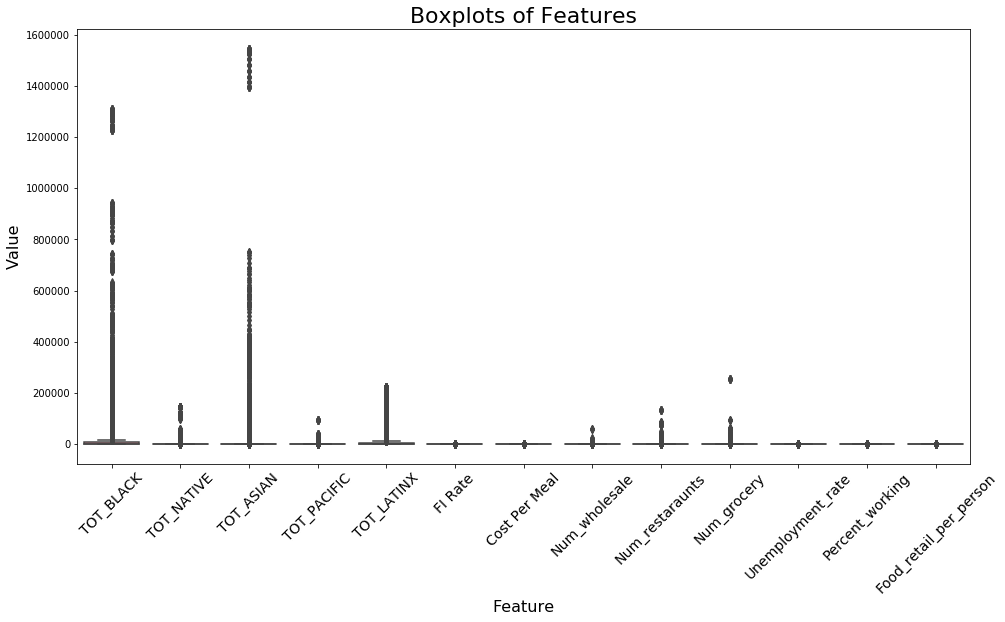

In [709]:
# create boxplot for each feature with outliers
plt.figure(figsize=(16, 8));
sns.boxplot(data= df.iloc[:,5:22]);
plt.title('Boxplots of Features', fontdict={'fontsize':22});
plt.ylabel('Value', fontdict={'fontsize':16});
plt.xlabel('Feature', fontdict={'fontsize':16});
plt.xticks(rotation=45,fontsize=14);


### Remove Outliers

In [916]:
# Bring outliers down/up to 5 standard deviations from the mean 
features = ['TOT_POP', 'TOT_MALE', 'TOT_FEMALE', 'TOT_BLACK', 'TOT_ASIAN','TOT_WHITE', 'TOT_LATINX',
            'Total_workforce', 'Employed']
for feat in features:
    abv_5_std = df[feat].mean()+ 1* df[feat].std()
    below_5_std = df[feat].mean()- 1* df[feat].std()
    conditions = [df[feat]>abv_5_std, df[feat]<below_5_std]
    choices = [abv_5_std, below_5_std]
    df[feat] = np.select(conditions, choices, df[feat])


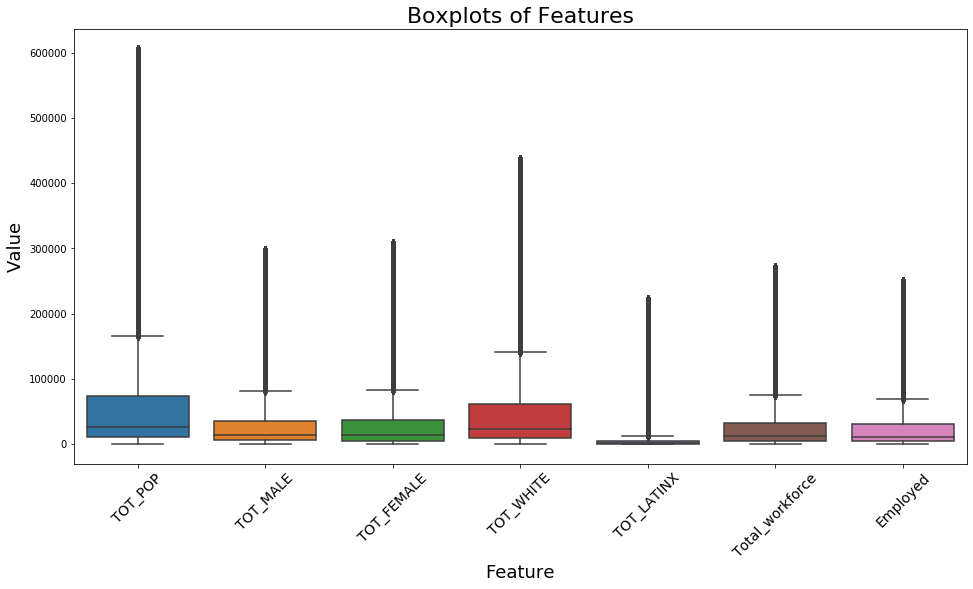

In [653]:
# create boxplot for each feature with outliers
plt.figure(figsize=(16, 8));
sns.boxplot(data= df[features]);
plt.title('Boxplots of Features', fontdict={'fontsize':22});
plt.ylabel('Value', fontdict={'fontsize':18});
plt.xlabel('Feature', fontdict={'fontsize':18});
plt.xticks(rotation=45,fontsize=14);

### Model without outliers

In [919]:
# Limit the year and drop null values
df[df.Year.isin(['2010','2011','2012','2013','2014','2015','2016','2017'
                 ,'2018','2019'])].dropna(subset=['Houseless_rate', 'FI Rate','Rent'],  how='all')

# isolate target variable and features
y = df_14['FI Rate']
X = df_14.drop([ 'FI Rate','Year'],axis=1)

# split into train test sets
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [920]:
# Instantiate Linear Regression model
model_2 = LinearRegression()
model_2.fit(X_train, y_train)
y_train_pred = model_2.predict(X_train)
y_test_pred = model_2.predict(X_test)

# R2 of training and test set
print('R2 Train:',model_2.score(X_train, y_train))
print('R2 Test:',model_2.score(X_test, y_test))

# RMSE of training and test set
print('RMSE Train:',np.sqrt(mean_squared_error(y_train, y_train_pred)))
print('RMSE Test:',np.sqrt(mean_squared_error(y_test, y_test_pred)))

scores =cross_val_score(model_2, X, y, cv=5,  scoring='r2')
print(scores)
np.mean(scores)

R2 Train: 0.7952408716210959
R2 Test: 0.7572438483285167
RMSE Train: 0.016437434876178575
RMSE Test: 0.019181613004504206
[0.62601032 0.76499788 0.79082477 0.51495285 0.55081073]


0.6495193118980744

# Feature Selection

In [578]:
df.columns

Index(['Rent', 'Year', 'Houseless_rate', 'Sheltered_rate', 'Unsheltered_rate',
       'TOT_POP', 'TOT_MALE', 'TOT_FEMALE', 'TOT_WHITE', 'TOT_BLACK',
       'TOT_NATIVE', 'TOT_ASIAN', 'TOT_PACIFIC', 'TOT_LATINX', 'FI Rate',
       'Cost Per Meal', 'Num_wholesale', 'Num_restaraunts', 'Num_grocery',
       'Total_workforce', 'Employed', 'Unemployed', 'Unemployment_rate',
       'Percent_male', 'Percent_female', 'Percent_white', 'Percent_Black',
       'Percent_native', 'Percent_asian', 'Percent_pacific', 'Percent_latinX',
       'Percent_working', 'Total_food_retail', 'Food_retail_per_person',
       'Lo_thresh_SNAP', 'Lo_thresh_SNAP_other', 'Hi_thresh_SNAP',
       'Hi_thresh_SNAP_other', 'Hi_thresh_other'],
      dtype='object')

## Multicollinearity 
### Inspect correlation between each feature pair

In [580]:
corr=df_14.iloc[:,1:].corr().abs().stack().reset_index().sort_values(0, ascending=False)
corr['pairs'] = list(zip(corr.level_0, corr.level_1))
corr.drop(columns=['level_1', 'level_0'], inplace = True)
corr.columns = ['correlation', 'pairs']
corr.drop_duplicates(inplace=True)
corr[(corr.correlation >0.95) & (corr.correlation <1.0)][:10]

,correlation,pairs
183,0.999788,"(TOT_FEMALE, TOT_POP)"
113,0.999788,"(TOT_POP, TOT_FEMALE)"
112,0.999768,"(TOT_POP, TOT_MALE)"
147,0.999768,"(TOT_MALE, TOT_POP)"
665,0.999731,"(Employed, Total_workforce)"
630,0.999731,"(Total_workforce, Employed)"
184,0.999119,"(TOT_FEMALE, TOT_MALE)"
149,0.999119,"(TOT_MALE, TOT_FEMALE)"
197,0.990766,"(TOT_FEMALE, Total_workforce)"
617,0.990766,"(Total_workforce, TOT_FEMALE)"


### VIF Scores

In [581]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif["features"] = X_train.columns
vif_features = vif[vif['VIF Factor'] <10]['features']
vif[vif['VIF Factor'] <10]

,VIF Factor,features
0,4.336934,Rent
13,4.312748,Cost Per Meal
20,5.169773,Unemployment_rate
25,9.790930,Percent_native
28,7.530413,Percent_latinX
29,4.141128,Percent_working
31,3.789823,Food_retail_per_person


In [582]:
# Observe model performance using only features with low VIF
model_2 = LinearRegression()
model_2.fit(X_train[vif_features], y_train)
print(model_2.score(X_train[vif_features],y_train))      
print(model_2.score(X_test[vif_features],y_test)) 

0.3894027940130268
0.3512521718860955


## K-Best Selector

In [923]:
# determine optimal k with a loop 

# for k in range(40,90):
#     selector = SelectKBest(f_regression, k=k)
#     selector.fit(X_train, y_train)
#     kbest_features = X_train.columns[selector.get_support()]
#     model_3 = LinearRegression()
#     model_3.fit(X_train[kbest_features], y_train)
#     y_test_pred = model_3.predict(X_test[kbest_features])
#     print(k,'\n', model_3.score(X_test[kbest_features],y_test))
#     print(np.mean(cross_val_score(model_1, X[kbest_features], y, cv=5,  scoring='r2')))


In [922]:
# run model with best k features
selector = SelectKBest(f_regression, k=83)
selector.fit(X_train, y_train)
kbest_features = X_train.columns[selector.get_support()]

model_3 = LinearRegression()
model_3.fit(X_train[kbest_features], y_train)
y_train_pred = model_3.predict(X_train[kbest_features])
y_test_pred = model_3.predict(X_test[kbest_features])

# R2 of training and test set
print('R2 Train:',model_3.score(X_train[kbest_features], y_train))
print('R2 Test:',model_3.score(X_test[kbest_features], y_test))

# RMSE of training and test set
print('RMSE Train:',np.sqrt(mean_squared_error(y_train, y_train_pred)))
print('RMSE Test:',np.sqrt(mean_squared_error(y_test, y_test_pred)))
kbest_features

R2 Train: 0.7947217833769439
R2 Test: 0.7601007768314274
RMSE Train: 0.01645825709400176
RMSE Test: 0.019068407458068943


Index(['Rent', 'Houseless_rate', 'Sheltered_rate', 'Unsheltered_rate',
       'TOT_POP', 'TOT_MALE', 'TOT_FEMALE', 'TOT_WHITE', 'TOT_BLACK',
       'TOT_NATIVE', 'TOT_ASIAN', 'TOT_PACIFIC', 'TOT_LATINX', 'Cost Per Meal',
       'Num_wholesale', 'Num_grocery', 'Total_workforce', 'Employed',
       'Unemployed', 'Unemployment_rate', 'Percent_male', 'Percent_female',
       'Percent_white', 'Percent_Black', 'Percent_native', 'Percent_asian',
       'Percent_pacific', 'Percent_latinX', 'Percent_working',
       'Total_food_retail', 'Food_retail_per_person',
       'Houseless_rate_X_Sheltered_rate', 'Rent_X_Percent_Black',
       'Houseless_rate_X_Percent_male', 'Houseless_rate_X_Percent_female',
       'Rent_X_Percent_working', 'Sheltered_rate_X_Percent_male',
       'Sheltered_rate_X_Percent_female', 'Rent_X_Cost Per Meal',
       'Rent_X_Percent_female', 'Rent_X_Percent_male',
       'Rent_X_Unemployment_rate', 'Percent_asian_X_Percent_working',
       'Unemployment_rate_X_Percent_Black'

## Recursive Feature Elimination

In [924]:
ols = LinearRegression()
selector = RFECV(estimator=ols, step=1, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
selector.fit(X_train, y_train)
rfe_features = X_train.columns[selector.support_]

In [925]:
model_4 = LinearRegression()
model_4.fit(X_train[rfe_features], y_train)
y_train_pred = model_4.predict(X_train[rfe_features])
y_test_pred = model_4.predict(X_test[rfe_features])

# R2 of training and test set
print('R2 Train:',model_4.score(X_train[rfe_features], y_train))
print('R2 Test:',model_4.score(X_test[rfe_features], y_test))

# RMSE of training and test set
print('RMSE Train:',np.sqrt(mean_squared_error(y_train, y_train_pred)))
print('RMSE Test:',np.sqrt(mean_squared_error(y_test, y_test_pred)))

R2 Train: 0.785555391264885
R2 Test: 0.7538718035966434
RMSE Train: 0.0168217035557983
RMSE Test: 0.019314376246171962
